In [1]:
import os
import torch
import clip
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
class BreastUltrasoundDataset(Dataset):
    """Custom Dataset for Breast Ultrasound Images."""
    def __init__(self, image_dir, transform=None, max_samples=None):
        self.image_dir = image_dir
        self.transform = transform
        self.class_names = ["normal", "benign", "malignant"]
        samples = []
        for idx, class_name in enumerate(self.class_names):
            class_folder = os.path.join(image_dir, class_name)
            image_files = [f for f in os.listdir(class_folder) if f.lower().endswith('.png')]
            for filename in image_files:
                samples.append((os.path.join(class_folder, filename), idx))
        if max_samples is not None:
            samples = samples[:max_samples]
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [4]:
# Paths and class names
image_root_dir = "./data/Dataset_BUSI_with_GT"  # Set this to your folder structure
class_names = ["normal", "benign", "malignant"]

# CLIP preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# Load dataset and split
full_dataset = BreastUltrasoundDataset(image_root_dir, transform=preprocess)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(f"Train/val split: {len(train_dataset)}/{len(val_dataset)}")

Train/val split: 1262/316


In [5]:
model_name = "ViT-B/32"
clip_model, _ = clip.load(model_name, device=device)
clip_model.eval()
print(f"Loaded CLIP: {model_name}")

Loaded CLIP: ViT-B/32


In [6]:
class CLIPFineTuner:
    """Fine-tuning class for BUSI/CLIP."""
    def __init__(self, clip_model, class_count, learning_rate=1e-3):
        self.clip_model = clip_model.eval()
        for param in self.clip_model.parameters():
            param.requires_grad = False
        feature_dim = clip_model.visual.output_dim
        self.classifier = nn.Linear(feature_dim, class_count).to(device)
        self.optimizer = optim.Adam(self.classifier.parameters(), lr=learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()
    def train_step(self, images, labels):
        self.optimizer.zero_grad()
        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)
        logits = self.classifier(image_features)
        loss = self.loss_fn(logits, labels)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    def train_epoch(self, dataloader):
        self.clip_model.eval()
        self.classifier.train()
        total_loss, correct, total_samples, batch_count = 0, 0, 0, 0
        for images, labels in tqdm(dataloader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            loss = self.train_step(images, labels)
            total_loss += loss
            with torch.no_grad():
                image_features = self.clip_model.encode_image(images)
                logits = self.classifier(image_features)
                predictions = logits.argmax(dim=1)
                correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
            batch_count += 1
        avg_loss = total_loss / batch_count
        train_acc = 100 * correct / total_samples
        return avg_loss, train_acc
    def evaluate(self, dataloader):
        self.clip_model.eval()
        self.classifier.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in tqdm(dataloader, desc="Evaluating"):
                images, labels = images.to(device), labels.to(device)
                image_features = self.clip_model.encode_image(images)
                logits = self.classifier(image_features)
                predictions = logits.argmax(dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
        accuracy = 100 * correct / total
        print(f"Fine-tuned accuracy: {accuracy:.2f}%")
        return accuracy

Evaluating: 100%|██████████| 79/79 [00:16<00:00,  4.93it/s]


Fine-tuned accuracy: 83.54%


Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.61it/s]


Fine-tuned accuracy: 83.86%


Evaluating: 100%|██████████| 79/79 [00:16<00:00,  4.70it/s]


Fine-tuned accuracy: 85.44%


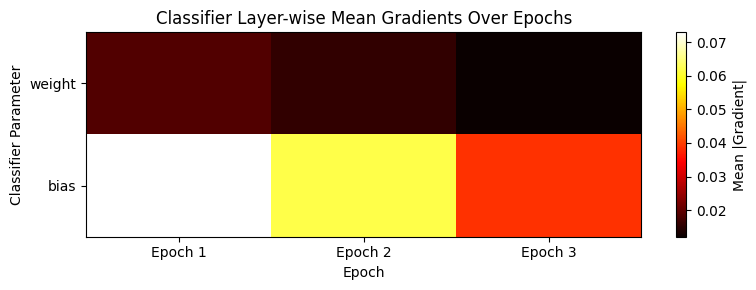

In [11]:
import numpy as np
import matplotlib.pyplot as plt

classifier_layer_names = [name for name, _ in tuner.classifier.named_parameters()]
num_layers = len(classifier_layer_names)
num_epochs = 3  # or your actual num_epochs

classifier_grads = np.zeros((num_layers, num_epochs))

for epoch in range(num_epochs):
    train_loss, train_acc = tuner.train_epoch(train_loader)
    
    images, labels = next(iter(train_loader))
    images, labels = images.to(device), labels.to(device)

    tuner.optimizer.zero_grad()
    with torch.no_grad():
        image_features = tuner.clip_model.encode_image(images)
    logits = tuner.classifier(image_features)
    loss = tuner.loss_fn(logits, labels)
    loss.backward()

    # mean absolute gradients for each classifier parameter
    for idx, (name, param) in enumerate(tuner.classifier.named_parameters()):
        if param.grad is not None:
            classifier_grads[idx, epoch] = param.grad.abs().mean().cpu().item()
        else:
            classifier_grads[idx, epoch] = 0.0

    val_acc = tuner.evaluate(val_loader)

# Plot as heatmap
plt.figure(figsize=(8, 3))
im = plt.imshow(classifier_grads, aspect='auto', cmap='hot')
plt.colorbar(im, label='Mean |Gradient|')
plt.yticks(range(num_layers), classifier_layer_names)
plt.xticks(range(num_epochs), [f'Epoch {i+1}' for i in range(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Classifier Parameter')
plt.title('Classifier Layer-wise Mean Gradients Over Epochs')
plt.tight_layout()
plt.show()

Evaluating: 100%|██████████| 79/79 [00:16<00:00,  4.92it/s]


Fine-tuned accuracy: 81.33%


Evaluating: 100%|██████████| 79/79 [00:16<00:00,  4.69it/s]


Fine-tuned accuracy: 82.59%


Evaluating: 100%|██████████| 79/79 [00:16<00:00,  4.78it/s]


Fine-tuned accuracy: 82.59%


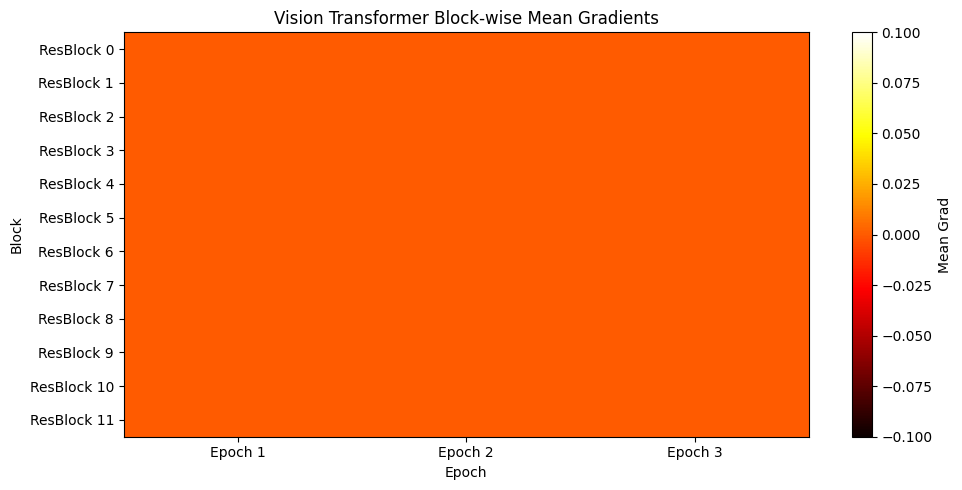

In [10]:
import torch
import numpy as np

num_epochs = 3  # or your actual number!

# 12 residual blocks in ViT-B/32
num_blocks = 12
block_names = [f"ResBlock {i}" for i in range(num_blocks)]
blockwise_grads = np.zeros((num_blocks, num_epochs))

# Helper: find all blocks
resblocks = tuner.clip_model.visual.transformer.resblocks

for epoch in range(num_epochs):
    # Train for one epoch...
    train_loss, train_acc = tuner.train_epoch(train_loader)
    # Do a backward pass on a batch to get gradients, e.g.:
    # loss.backward()  # make sure .grad fields are populated!

    # Gather block-wise mean gradients
    for i, block in enumerate(resblocks):
        grads = []
        for name, param in block.named_parameters():
            if param.grad is not None:
                grads.append(param.grad.abs().mean().cpu().item())
        blockwise_grads[i, epoch] = np.mean(grads) if grads else 0.0

    val_acc = tuner.evaluate(val_loader)

# Now plot blockwise_grads as a heatmap!
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.imshow(blockwise_grads, aspect='auto', cmap='hot')
plt.colorbar(label='Mean Grad')
plt.yticks(range(num_blocks), block_names)
plt.xticks(range(num_epochs), [f"Epoch {i+1}" for i in range(num_epochs)])
plt.xlabel("Epoch")
plt.ylabel("Block")
plt.title("Vision Transformer Block-wise Mean Gradients")
plt.tight_layout()
plt.show()